In [2]:
import random
import math

class Maze:
    def __init__(self, n):
        """
        Initialize the maze of size (n+2) x (n+2) including a border of walls.
        The interior maze is generated by randomly placing floor(0.05 * n * n) walls.
        The generation is repeated until the interior blank cells are all connected.
        """
        self.n = n
        self.size = n + 2
        self.maze = [['#' for _ in range(self.size)] for _ in range(self.size)]

        # Two sets for storing coordinates of walls and blanks
        self.wall_coords = set()
        self.blank_coords = set()

        # List to store the station coordinates
        self.stations = []

        # Lists to store taxi and passenger information
        self.taxi_location = []
        self.pass_idx = None  # Station index (0-3) for passenger location
        self.dest_idx = None  # Station index (0-3) for destination
        self.passenger_loc = None  # Actual coordinates of passenger location
        self.destination = None  # Actual coordinates of destination
        self.passenger_picked_up = False  # Track if passenger is in taxi
        self.fuel = 5000  # Initialize fuel

        # Generate the maze on initialization using the new algorithm
        self._generate_maze()

        # Fill in the wall_coords and blank_coords sets based on the final maze
        self._populate_coordinate_sets()

        # Select the stations ensuring they are not adjacent
        self._select_stations()

        # Select taxi location and passenger information
        self._select_taxi_and_passenger()

    def _generate_maze(self):
        """
        Generate a maze by randomly placing floor(0.05 * n * n) walls in the interior.
        Repeats until the interior blank cells (ignoring boundary walls) are fully connected.
        """
        count_walls = math.floor(0.1 * self.n * self.n)
        while True:
            # Reset maze with boundary walls and interior blanks.
            self.maze = [['#' for _ in range(self.size)] for _ in range(self.size)]
            for r in range(1, self.n + 1):
                for c in range(1, self.n + 1):
                    self.maze[r][c] = ' '

            # Randomly place the walls in the interior.
            interior_coords = [(r, c) for r in range(1, self.n + 1) for c in range(1, self.n + 1)]
            wall_cells = random.sample(interior_coords, count_walls)
            for (r, c) in wall_cells:
                self.maze[r][c] = '#'

            # Check if the interior blank cells are all connected.
            if self._is_connected():
                break

    def _is_connected(self):
        """
        Check if all blank cells in the interior (ignoring the boundary walls) are connected.
        Returns True if connected, False otherwise.
        """
        visited = set()
        start = None
        # Find a starting blank cell in the interior.
        for r in range(1, self.n + 1):
            for c in range(1, self.n + 1):
                if self.maze[r][c] == ' ':
                    start = (r, c)
                    break
            if start is not None:
                break

        if start is None:
            return False  # No blank cell available.

        # Flood fill (using DFS) to traverse connected blank cells.
        stack = [start]
        while stack:
            (r, c) = stack.pop()
            if (r, c) in visited:
                continue
            visited.add((r, c))
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nr, nc = r + dr, c + dc
                if 1 <= nr <= self.n and 1 <= nc <= self.n and self.maze[nr][nc] == ' ' and (nr, nc) not in visited:
                    stack.append((nr, nc))

        # Count the total number of blank cells in the interior.
        total_blank = sum(1 for r in range(1, self.n + 1) for c in range(1, self.n + 1) if self.maze[r][c] == ' ')
        return len(visited) == total_blank

    def _populate_coordinate_sets(self):
        """
        Populate wall_coords and blank_coords based on the final layout in self.maze.
        """
        self.wall_coords.clear()
        self.blank_coords.clear()
        for r in range(self.size):
            for c in range(self.size):
                if self.maze[r][c] == '#':
                    self.wall_coords.add((r, c))
                else:
                    self.blank_coords.add((r, c))

    def _select_stations(self):
        """
        Randomly selects 4 blank cells to serve as stations, ensuring that
        no two stations are adjacent (cardinally). Repeats the selection until valid.
        """
        while True:
            blank_list = list(self.blank_coords)
            if len(blank_list) < 4:
                # If there aren't enough blanks, assign whatever is available.
                self.stations = [list(coord) for coord in blank_list]
                break
            selected_coords = random.sample(blank_list, 4)

            # Check that no two selected stations are adjacent (Manhattan distance == 1).
            valid = True
            for i in range(len(selected_coords)):
                for j in range(i + 1, len(selected_coords)):
                    r1, c1 = selected_coords[i]
                    r2, c2 = selected_coords[j]
                    if abs(r1 - r2) + abs(c1 - c2) == 1:
                        valid = False
                        break
                if not valid:
                    break
            if valid:
                self.stations = [list(coord) for coord in selected_coords]
                break

    def _select_taxi_and_passenger(self):
        """
        Randomly selects a blank cell for the taxi (not a station).
        Randomly selects two different stations for passenger location and destination.
        """
        station_coords = {tuple(station) for station in self.stations}
        available_coords = list(self.blank_coords - station_coords)

        if available_coords:
            taxi_coord = random.choice(available_coords)
            self.taxi_location = list(taxi_coord)
        else:
            self.taxi_location = []

        if len(self.stations) >= 2:
            station_indices = list(range(len(self.stations)))
            selected_indices = random.sample(station_indices, 2)
            self.pass_idx = selected_indices[0]
            self.dest_idx = selected_indices[1]
            self.passenger_loc = self.stations[self.pass_idx]
            self.destination = self.stations[self.dest_idx]
        else:
            self.pass_idx = None
            self.dest_idx = None
            self.passenger_loc = None
            self.destination = None

    def step(self, action):
        """
        Execute an action and update the environment state.

        Args:
            action (int):
                0: Move south
                1: Move north
                2: Move east
                3: Move west
                4: Pick up passenger
                5: Drop off passenger

        Returns:
            tuple: (observation, reward, done, False, False)
        """
        reward = -0.1  # Each step costs -0.1
        self.fuel -= 1

        if self.fuel <= 0:
            return self.get_state(), reward - 10, True, False, False  # Fuel exhaustion penalty

        if 0 <= action <= 3:
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            dr, dc = directions[action]
            new_r, new_c = self.taxi_location[0] + dr, self.taxi_location[1] + dc

            if (new_r, new_c) in self.wall_coords:
                reward -= 5  # Penalty for hitting a wall
                return self.get_state(), reward, False, False, False

            self.taxi_location = [new_r, new_c]

        elif action == 4:  # Pick up passenger
            if not self.passenger_picked_up and self.taxi_location == self.passenger_loc:
                self.passenger_picked_up = True
            else:
                reward -= 10  # Penalty for incorrect pickup

        elif action == 5:  # Drop off passenger
            if self.passenger_picked_up and self.taxi_location == self.destination:
                self.passenger_picked_up = False
                reward += 50  # Reward for successful delivery
                self._randomize_passenger_and_destination()
            else:
                reward -= 10  # Penalty for incorrect dropoff

        return self.get_state(), reward, False, False, False

    def _randomize_passenger_and_destination(self):
        """
        Randomly selects new passenger and destination stations (they must be different).
        """
        if len(self.stations) >= 2:
            station_indices = list(range(len(self.stations)))
            selected_indices = random.sample(station_indices, 2)
            self.pass_idx = selected_indices[0]
            self.dest_idx = selected_indices[1]
            self.passenger_loc = self.stations[self.pass_idx]
            self.destination = self.stations[self.dest_idx]
            self.passenger_picked_up = False

    def __str__(self):
        """
        Return a string representation of the maze for printing.
        """
        return "\n".join("".join(row) for row in self.maze)

    def get_state(self):
        """
        Returns the current state representation as a tuple containing:
        - Taxi position (adjusted by -1 to ignore the border)
        - Station coordinates (padded to ensure 4 stations, adjusted by -1)
        - Obstacle flags in the four cardinal directions
        - Passenger and destination visibility flags

        Returns:
            tuple: State representation
        """
        taxi_row, taxi_col = self.taxi_location
        obstacle_north = int((taxi_row - 1, taxi_col) in self.wall_coords)
        obstacle_south = int((taxi_row + 1, taxi_col) in self.wall_coords)
        obstacle_east  = int((taxi_row, taxi_col + 1) in self.wall_coords)
        obstacle_west  = int((taxi_row, taxi_col - 1) in self.wall_coords)

        padded_stations = self.stations + [[0, 0]] * (4 - len(self.stations))

        passenger_loc = self.passenger_loc
        passenger_loc_north = int(passenger_loc == [taxi_row - 1, taxi_col])
        passenger_loc_south = int(passenger_loc == [taxi_row + 1, taxi_col])
        passenger_loc_east  = int(passenger_loc == [taxi_row, taxi_col + 1])
        passenger_loc_west  = int(passenger_loc == [taxi_row, taxi_col - 1])
        passenger_loc_middle = int(passenger_loc == [taxi_row, taxi_col])
        passenger_look = (passenger_loc_north or passenger_loc_south or
                          passenger_loc_east or passenger_loc_west or passenger_loc_middle)

        destination = self.destination
        destination_loc_north = int(destination == [taxi_row - 1, taxi_col])
        destination_loc_south = int(destination == [taxi_row + 1, taxi_col])
        destination_loc_east  = int(destination == [taxi_row, taxi_col + 1])
        destination_loc_west  = int(destination == [taxi_row, taxi_col - 1])
        destination_loc_middle = int(destination == [taxi_row, taxi_col])
        destination_look = (destination_loc_north or destination_loc_south or
                            destination_loc_east or destination_loc_west or destination_loc_middle)

        state = (
            taxi_row - 1, taxi_col - 1,
            padded_stations[3][0] - 1, padded_stations[3][1] - 1,
            padded_stations[2][0] - 1, padded_stations[2][1] - 1,
            padded_stations[1][0] - 1, padded_stations[1][1] - 1,
            padded_stations[0][0] - 1, padded_stations[0][1] - 1,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        )
        return state

def interactive_test(maze_size=6):
    """
    Interactive testing function that allows manual control of the taxi.

    Args:
        maze_size (int): Size of the maze to generate
    """
    # Initialize maze
    maze_obj = Maze(maze_size)
    done = False
    total_reward = 0

    # Display the initial state
    clear_screen()
    display_state(maze_obj)

    # Main interaction loop
    while not done:
        # Get action from user
        action = get_user_action()

        if action == -1:
            print("Exiting interactive test...")
            break

        # Execute the action
        obs, reward, done, _, _ = maze_obj.step(action)
        total_reward += reward

        # Display the updated state
        clear_screen()
        display_state(maze_obj)
        display_observation(obs)

        # Show action result
        print(f"Action: {action_to_string(action)}")
        print(f"Reward: {reward:.1f}")
        print(f"Total Reward: {total_reward:.1f}")

        if done:
            print("Game over! (Fuel depleted)")

        # Success message for pickup and dropoff
        if action == 4 and maze_obj.passenger_picked_up:
            print("Passenger picked up successfully!")
        elif action == 5 and not maze_obj.passenger_picked_up and reward > 0:
            print("Passenger delivered successfully!")
            print("New passenger and destination have been assigned!")

def clear_screen():
    """Clear the terminal screen."""
    print("\033[H\033[J", end="")  # ANSI escape sequence to clear screen

def action_to_string(action):
    """Convert action number to descriptive string with key mapping."""
    actions = {
        0: "Move South (S)",
        1: "Move North (W)",
        2: "Move East (D)",
        3: "Move West (A)",
        4: "Pick up passenger (P)",
        5: "Drop off passenger (O)"
    }
    return actions.get(action, "Unknown")

def get_user_action():
    """Get action input from the user using keyboard-style controls."""
    print("\nAvailable actions:")
    print("W: Move North")
    print("A: Move West")
    print("S: Move South")
    print("D: Move East")
    print("P: Pick up passenger")
    print("O: Drop off passenger")
    print("Q: Quit")

    # Action mapping from keyboard controls to action numbers
    action_map = {
        'w': 1,  # North
        'a': 3,  # West
        's': 0,  # South
        'd': 2,  # East
        'p': 4,  # Pick up
        'o': 5,  # Drop off
    }

    while True:
        user_input = input("\nEnter action: ").strip().lower()

        if user_input == 'q':
            return -1
        elif user_input in action_map:
            return action_map[user_input]
        else:
            print("Invalid input. Please use W/A/S/D for movement, P to pick up, O to drop off, or Q to quit.")

def display_state(maze_obj):
    """Display the current state of the maze with taxi, passenger, and destination."""
    # Create a visual representation of the maze
    original_maze = [row[:] for row in maze_obj.maze]

    # Transpose the maze (swap rows and columns)
    visual_maze = [[original_maze[j][i] for j in range(maze_obj.size)] for i in range(maze_obj.size)]

    # Mark stations with numbers (note: coordinates are now swapped)
    for i, station in enumerate(maze_obj.stations):
        r, c = station
        visual_maze[c][r] = str(i)  # Notice the swap of r,c to c,r

    # Mark taxi position with 'T' (coordinates swapped)
    taxi_r, taxi_c = maze_obj.taxi_location
    visual_maze[taxi_c][taxi_r] = 'T'  # Swap r,c

    # If passenger is not picked up, mark their position with 'P'
    if not maze_obj.passenger_picked_up and maze_obj.passenger_loc:
        p_r, p_c = maze_obj.passenger_loc
        if [p_r, p_c] != maze_obj.taxi_location:  # Don't overwrite taxi
            visual_maze[p_c][p_r] = 'P'  # Swap r,c

    # Mark destination with 'D'
    if maze_obj.destination:
        d_r, d_c = maze_obj.destination
        if [d_r, d_c] != maze_obj.taxi_location:  # Don't overwrite taxi
            visual_maze[d_c][d_r] = 'D'  # Swap r,c

    # Print the maze
    print("\nCurrent Maze (Transposed):")
    print("-" * (maze_obj.size + 2))
    for row in visual_maze:
        print("|" + "".join(row) + "|")
    print("-" * (maze_obj.size + 2))

    # Print status information
    print(f"\nTaxi Location: {maze_obj.taxi_location}")
    print(f"Passenger Station: {maze_obj.pass_idx}")
    print(f"Destination Station: {maze_obj.dest_idx}")
    print(f"Passenger Picked Up: {'Yes' if maze_obj.passenger_picked_up else 'No'}")
    print(f"Fuel Remaining: {maze_obj.fuel}")

def display_observation(obs):
    """Display the observation tuple in a readable format."""
    if not obs:
        print("No observation available")
        return

    # Unpack the observation
    taxi_row, taxi_col = obs[0], obs[1]
    stations = [
        [obs[2], obs[3]],  # Station 0
        [obs[4], obs[5]],  # Station 1
        [obs[6], obs[7]],  # Station 2
        [obs[8], obs[9]]   # Station 3
    ]
    obstacle_north = obs[10]
    obstacle_south = obs[11]
    obstacle_east = obs[12]
    obstacle_west = obs[13]
    passenger_visible = obs[14]
    destination_visible = obs[15]

    # Print in a formatted way
    print("\nObservation Details:")
    print(f"  {obs}")
    directions = []
    if obstacle_north: directions.append("North")
    if obstacle_south: directions.append("South")
    if obstacle_east: directions.append("East")
    if obstacle_west: directions.append("West")
    print(", ".join(directions) if directions else "None")
    print(f"  Passenger visible: {'Yes' if passenger_visible else 'No'}")
    print(f"  Destination visible: {'Yes' if destination_visible else 'No'}")


Using device: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 1000/10000 | Avg Score: -1658.11 | Avg Loss: 1.8623 | Epsilon: 0.6065
Episode 2000/10000 | Avg Score: -1099.37 | Avg Loss: 0.3432 | Epsilon: 0.3678
Episode 3000/10000 | Avg Score: -691.15 | Avg Loss: 0.1112 | Epsilon: 0.2230
Episode 4000/10000 | Avg Score: -439.12 | Avg Loss: 0.0845 | Epsilon: 0.1353
Episode 5000/10000 | Avg Score: -283.61 | Avg Loss: 0.0497 | Epsilon: 0.0820
Episode 6000/10000 | Avg Score: -194.25 | Avg Loss: 0.0281 | Epsilon: 0.0497
Episode 7000/10000 | Avg Score: -137.14 | Avg Loss: 0.0340 | Epsilon: 0.0302
Episode 8000/10000 | Avg Score: -102.94 | Avg Loss: 0.0227 | Epsilon: 0.0183
Episode 9000/10000 | Avg Score: -82.85 | Avg Loss: 0.0150 | Epsilon: 0.0111
Episode 10000/10000 | Avg Score: -72.13 | Avg Loss: 0.0118 | Epsilon: 0.0100


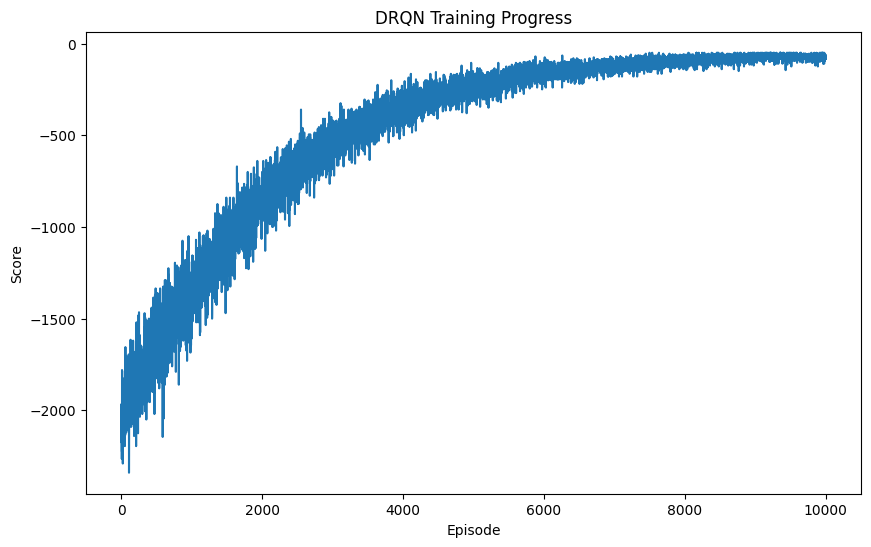

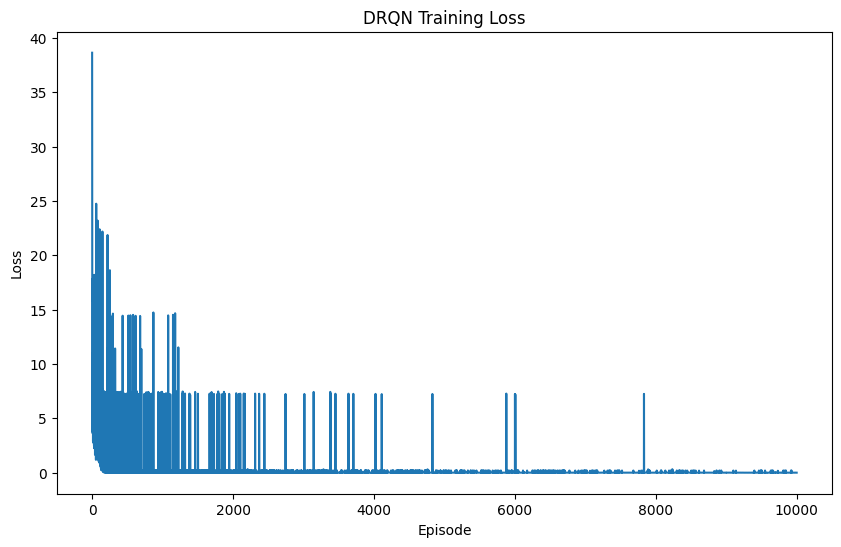

Eval Episode 1: Total Reward = -65.00, Steps = 500
Eval Episode 2: Total Reward = -80.00, Steps = 500
Eval Episode 3: Total Reward = -95.00, Steps = 500
Eval Episode 4: Total Reward = -75.00, Steps = 500
Eval Episode 5: Total Reward = -100.00, Steps = 500
Eval Episode 6: Total Reward = -85.00, Steps = 500
Eval Episode 7: Total Reward = -75.00, Steps = 500
Eval Episode 8: Total Reward = -50.00, Steps = 500
Eval Episode 9: Total Reward = -90.00, Steps = 500
Eval Episode 10: Total Reward = -85.00, Steps = 500
Average Reward over 10 episodes: -80.00
Training complete!


In [7]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm

# ---------------- State Parsing ----------------

def parse_state(obs):
    """
    Parses the raw state tuple into a structured tuple.
    """
    padded_stations = [
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]
    ]
    (
        taxi_row,
        taxi_col,
        padded_stations[0][0],
        padded_stations[0][1],
        padded_stations[1][0],
        padded_stations[1][1],
        padded_stations[2][0],
        padded_stations[2][1],
        padded_stations[3][0],
        padded_stations[3][1],
        obstacle_north,
        obstacle_south,
        obstacle_east,
        obstacle_west,
        passenger_look,
        destination_look
    ) = obs

    lst = []
    for station in padded_stations:
        station_row, station_col = station
        taxi_distance = abs(taxi_row - station_row) + abs(taxi_col - station_col)
        lst.append(taxi_distance)

    return (
        taxi_row,
        taxi_col,
        padded_stations[0][0],
        padded_stations[0][1],
        padded_stations[1][0],
        padded_stations[1][1],
        padded_stations[2][0],
        padded_stations[2][1],
        padded_stations[3][0],
        padded_stations[3][1],
        lst[0],
        lst[1],
        lst[2],
        lst[3],
        obstacle_north,
        obstacle_south,
        obstacle_east,
        obstacle_west,
        passenger_look,
        destination_look
    )

# ---------------- DRQN Network ----------------

class DRQN(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, action_size):
        super(DRQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, lstm_hidden_size, batch_first=True)
        self.fc2 = nn.Linear(lstm_hidden_size, action_size)

    def forward(self, x, hidden_state=None):
        # x shape: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()
        x = torch.relu(self.fc1(x))
        if hidden_state is None:
            h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            hidden_state = (h0, c0)
        x, hidden_state = self.lstm(x, hidden_state)
        q_values = self.fc2(x)  # shape: (batch, seq_len, action_size)
        return q_values, hidden_state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DRQNAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lstm_hidden_size=64,
                 gamma=0.99, learning_rate=0.001, tau=0.001,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995, chunk_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.chunk_size = chunk_size  # for truncated BPTT

        self.policy_net = DRQN(state_size, hidden_size, lstm_hidden_size, action_size).to(device)
        self.target_net = DRQN(state_size, hidden_size, lstm_hidden_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

    def reset_hidden_state(self, batch_size=1):
        h0 = torch.zeros(1, batch_size, self.policy_net.lstm.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.policy_net.lstm.hidden_size).to(device)
        return (h0, c0)

    def act(self, state, hidden_state):
        """
        Choose an action using an epsilon-greedy policy.
        state: tuple or numpy array of shape (state_size,)
        hidden_state: current hidden state tuple for the LSTM.
        Returns: action (int) and updated hidden state.
        """
        # Expand dimensions: (1, 1, state_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        if random.random() < self.epsilon:
            action = random.randrange(self.action_size)
            # Update hidden state with a forward pass
            with torch.no_grad():
                _, hidden_state = self.policy_net(state_tensor, hidden_state)
            return action, hidden_state
        else:
            self.policy_net.eval()
            with torch.no_grad():
                q_values, hidden_state = self.policy_net(state_tensor, hidden_state)
            self.policy_net.train()
            action = torch.argmax(q_values, dim=2).item()
            return action, hidden_state

    def learn_from_episode(self, episode):
        """
        Learns from a single episode using truncated BPTT.
        Each element in 'episode' is a tuple: (state, action, reward, next_state, done)
        """
        seq_len = len(episode)
        if seq_len < 1:
            return 0

        # Prepare arrays
        states = np.array([transition[0] for transition in episode], dtype=np.float32)
        actions = np.array([transition[1] for transition in episode], dtype=np.int64)
        rewards = np.array([transition[2] for transition in episode], dtype=np.float32)
        next_states = np.array([transition[3] for transition in episode], dtype=np.float32)
        dones = np.array([transition[4] for transition in episode], dtype=np.float32)

        loss_total = 0.0
        num_chunks = 0

        # Initialize hidden state for the sequence
        hidden_state = self.reset_hidden_state()

        # Process episode in chunks
        for start in range(0, seq_len, self.chunk_size):
            end = min(start + self.chunk_size, seq_len)
            chunk_states = torch.FloatTensor(states[start:end]).unsqueeze(0).to(device)      # (1, chunk_len, state_size)
            chunk_actions = torch.LongTensor(actions[start:end]).unsqueeze(0).to(device)       # (1, chunk_len)
            chunk_rewards = torch.FloatTensor(rewards[start:end]).unsqueeze(0).to(device)      # (1, chunk_len)
            chunk_next_states = torch.FloatTensor(next_states[start:end]).unsqueeze(0).to(device)
            chunk_dones = torch.FloatTensor(dones[start:end]).unsqueeze(0).to(device)

            # Forward pass through policy network for current chunk
            q_values, hidden_state = self.policy_net(chunk_states, hidden_state)
            # Select Q-values corresponding to actions taken
            q_values = q_values.gather(2, chunk_actions.unsqueeze(-1)).squeeze(-1)

            # Compute target Q-values using target network.
            # For target network we use a fresh hidden state to avoid backprop through time
            with torch.no_grad():
                target_hidden = self.reset_hidden_state()
                q_next, _ = self.target_net(chunk_next_states, target_hidden)
                max_q_next = q_next.max(dim=2)[0]
                targets = chunk_rewards + self.gamma * max_q_next * (1 - chunk_dones)

            loss = nn.MSELoss()(q_values, targets)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1)
            self.optimizer.step()

            loss_total += loss.item()
            num_chunks += 1

            # Detach hidden state to truncate backpropagation
            hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

        self.soft_update()
        return loss_total / num_chunks if num_chunks > 0 else 0

    def soft_update(self):
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save({
            'policy_model_state_dict': self.policy_net.state_dict(),
            'target_model_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename)
        self.policy_net.load_state_dict(checkpoint['policy_model_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

# ---------------- Training and Evaluation ----------------

def train_drqn(num_episodes=100000, max_steps=1000, print_every=1000):
    scores = []
    agent_losses = []

    # Create a dummy environment to determine state dimension.
    env = Maze(random.randint(5, 10))
    state_size = 20
    action_size = 6
    agent = DRQNAgent(state_size, action_size)

    for episode in tqdm(range(1, num_episodes+1)):
        env = Maze(random.randint(5, 10))
        this_state_raw = env.get_state()
        this_state = parse_state(this_state_raw)
        hidden_state = agent.reset_hidden_state()
        episode_transitions = []
        total_reward = 0

        for t in range(max_steps):
            action, hidden_state = agent.act(this_state, hidden_state)
            next_state_raw, reward, done, _, _ = env.step(action)
            next_state = parse_state(next_state_raw)
            total_reward += reward
            episode_transitions.append((this_state, action, reward, next_state, float(done)))
            this_state = next_state
            if done:
                break

        if len(episode_transitions) > 1:
            loss = agent.learn_from_episode(episode_transitions)
            agent_losses.append(loss)

        scores.append(total_reward)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        if episode % print_every == 0:
            avg_score = np.mean(scores[-print_every:])
            avg_loss = np.mean(agent_losses[-print_every:]) if agent_losses else 0
            print(f"Episode {episode}/{num_episodes} | Avg Score: {avg_score:.2f} | Avg Loss: {avg_loss:.4f} | Epsilon: {agent.epsilon:.4f}")
            agent.save(f"drqn_checkpoint_ep{episode}.pt")

    agent.save("drqn_final.pt")

    plt.figure(figsize=(10,6))
    plt.plot(scores)
    plt.title("DRQN Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(agent_losses)
    plt.title("DRQN Training Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.show()

    return agent, scores

def evaluate_drqn(agent, num_episodes=10, max_steps=1000, render=False):
    total_rewards = []
    for episode in range(num_episodes):
        env = Maze(random.randint(5, 10))
        state = parse_state(env.get_state())  # Use the correct parser here
        hidden_state = agent.reset_hidden_state()
        total_reward = 0
        steps = 0

        while steps < max_steps:
            action, hidden_state = agent.act(state, hidden_state)
            next_state_raw, reward, done, _, _ = env.step(action)
            next_state = parse_state(next_state_raw)
            total_reward += reward
            state = next_state
            steps += 1
            if done:
                break
        total_rewards.append(total_reward)
        print(f"Eval Episode {episode+1}: Total Reward = {total_reward:.2f}, Steps = {steps}")

    print(f"Average Reward over {num_episodes} episodes: {np.mean(total_rewards):.2f}")
    return total_rewards

def main_func():
    # For quicker testing, reduce the number of episodes and max steps.
    agent, scores = train_drqn(num_episodes=10000, max_steps=500, print_every=1000)
    eval_rewards = evaluate_drqn(agent, num_episodes=10, max_steps=500, render=False)
    print("Training complete!")

main_func()